In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [3]:
import numpy as np
from scipy.stats import kendalltau
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [5]:
def read_memfile(filename, shape, dtype='float32'):
    # read binary data and return as a numpy array
    fp = np.memmap(filename, dtype=dtype, mode='r', shape=shape)
    data = np.zeros(shape=shape, dtype=dtype)
    data[:] = fp[:]
    del fp
    return data

In [6]:
def write_memfile(data, filename):
    # write a numpy array 'data' into a binary  data file specified by
    # 'filename'
    shape = data.shape
    dtype = data.dtype
    fp = np.memmap(filename, dtype=dtype, mode='w+', shape=shape)
    fp[:] = data[:]
    del fp

In [7]:
ROOT_DIR = '/rap/jvb-000-aa/COURS2019/etudiants/data/omsignal/myHeartProject/'
TRAIN_LABELED_FILE = 'MILA_TrainLabeledData.dat'
VALIDATION_LABELED_FILE =  'MILA_ValidationLabeledData.dat'

TRAIN_LABELED_FILE = 'MILA_TrainLabeledData.dat'
VALIDATION_LABELED_FILE = 'MILA_ValidationLabeledData.dat'
LABELS_NAME = ["PR_Mean", "RT_Mean", "RR_StdDev", "ID"]

train_labeled_data_file = os.path.join(ROOT_DIR, TRAIN_LABELED_FILE)
validation_labeled_data_file = os.path.join(ROOT_DIR, VALIDATION_LABELED_FILE)

In [8]:
datatrain = read_memfile(train_labeled_data_file, shape=(160,3754))
train_data, train_labels = datatrain[:,:-4], datatrain[:,-4:]

In [9]:
datavalid = read_memfile(validation_labeled_data_file, shape=(160,3754))
valid_data, valid_labels = datavalid[:,:-4], datavalid[:,-4:]

In [10]:
class Preprocessor(nn.Module):

    def __init__(
            self,
            ma_window_size=2,
            mv_window_size=4,
            num_samples_per_second=125):
        # ma_window_size: (in seconds) window size to use
        #                 for moving average baseline wander removal
        # mv_window_size: (in seconds) window size to use
        #                 for moving average RMS normalization

        super(Preprocessor, self).__init__()

        # Kernel size to use for moving average baseline wander removal: 2
        # seconds * 125 HZ sampling rate, + 1 to make it odd

        self.maKernelSize = (ma_window_size * num_samples_per_second) + 1

        # Kernel size to use for moving average normalization: 4
        # seconds * 125 HZ sampling rate , + 1 to make it odd

        self.mvKernelSize = (mv_window_size * num_samples_per_second) + 1

    def forward(self, x):

        with torch.no_grad():
            x = x.unsqueeze(0)
            

            # Remove window mean and standard deviation

            x = (x - torch.mean(x, dim=2, keepdim=True)) / \
                (torch.std(x, dim=2, keepdim=True) + 0.00001)

            # Moving average baseline wander removal

            x = x - F.avg_pool1d(
                x, kernel_size=self.maKernelSize,
                stride=1, padding=(self.maKernelSize - 1) // 2
            )

            # Moving RMS normalization

            x = x / (
                torch.sqrt(
                    F.avg_pool1d(
                        torch.pow(x, 2),
                        kernel_size=self.mvKernelSize,
                        stride=1, padding=(self.mvKernelSize - 1) // 2
                    )) + 0.00001
            )

        # Don't backpropagate further

        x = x.detach().contiguous()

        return x.squeeze(0)

In [11]:
def Plot_ECG(data, start=0, end=30, index_nb=[0], seconde=True):
    """
    Plot the ECG on a user defined time interval
    
    Parameters
    ----------
    data : numpy array
        The ECG Data
    start: int
        The starting time of the part of the ECG you want to plot
    end: int
        The End time of the part of the ECG you want to plot
    index_nb: List
        The index of the observation you want to plot
    seconde: boolean
        Used True if the start time is in seconde
    """
    # Adjust the shape in order to have 2 dimension
    if len(data.shape) == 1:
        data = np.expand_dims(data, axis=0)
        
    # Transform the start and end time 
    if seconde == True:
        start = start*125
        end = end*125
        
    x_labels = np.arange(start, end)
             
    for i, ex in enumerate(index_nb):
        plt.figure(i*2+1) 
        plt.plot(x_labels, data[ex, start:end])
        
    plt.show

In [12]:
class id_trasformer:
    def __init__(self):
        self.DictId2Class = {}
        self.DictClass2Id = {}
        self.n_Id = 0 
        
    def create_dict_ID(self, ID_vector):
        for id in ID_vector:
            if id not in self.DictId2Class:
                self.DictId2Class[id] = self.n_Id
                self.DictClass2Id[self.n_Id] = id
                self.n_Id += 1
                
    def Id2Class(self, ID_vector):
        return [self.DictId2Class[id] for id in ID_vector]
    
    def Class2Id(self, class_vector):
        return [self.DictClass2Id[labels] for labels in class_vector]

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [14]:
preprocessor = Preprocessor().to(device)

In [15]:
train = torch.tensor(train_data).to(device)
valid =  torch.tensor(valid_data).to(device)
preprocess_train = preprocessor(train)
preprocess_valid = preprocessor(valid)

In [16]:
idtransformer = id_trasformer()
idtransformer.create_dict_ID(train_labels[:,-1])
train_labels[:,-1] = idtransformer.Id2Class(train_labels[:,-1])
valid_labels[:,-1] = idtransformer.Id2Class(valid_labels[:,-1])

Algo to detect R P,T peak and onset offset based on https://pure.tugraz.at/ws/portalfiles/portal/1312717/Online%20and%20Offline%20Determination%20of%20QT%20PR%20in%20Electrocardiography%20LNCS%207719.pdfdf.pdf

In [17]:
def detect_R_peak(data, SADA_wd_size = 7, FS_wd_size = 12, Threshold = 35):
    """
    Take a Batch of ECG data and find the location of the R Peak
    
    The algorithm is based on the paper:
    Online and Offline Determination of QT and PR Interval and QRS Duration in Electrocardiography
    (Bachler et al., 2012)
    The variable name and default value follow the paper
    
    Parameters
    ----------
    data : numpy array
        The ECG Data (batch size x lenght of the ECG recording)
    SADA_wd_size: int
        size of the moving window used in the calculation of SA and DA
    FS_wd_size: int
        size of the moving window used in the calculation of the feature signal FS
    Threshold: int
        FS is compared to the Threshold to determined if its a QRS zone. 
    """
    
    R_peak = []
    
    #Allow batch size of 1
    if len(data.size()) == 1:
        data = data.unsqueeze(0)
    
    D = data[:, 1:] - data[:, 0:-1]
    
    
    data = data.unsqueeze(0)
    D = D.unsqueeze(0)
    SA = F.max_pool1d(data, kernel_size = SADA_wd_size, stride = 1)
    SA = SA + F.max_pool1d(-data, kernel_size = SADA_wd_size, stride = 1) 
    DA = F.max_pool1d(D, kernel_size = SADA_wd_size, stride = 1, padding=1)
    DA = DA + F.max_pool1d(-D, kernel_size = SADA_wd_size, stride = 1, padding=1) 
    
    C = DA[:,:,1:] * torch.pow(SA, 2)
    FS = F.max_pool1d(C, kernel_size = FS_wd_size, stride = 1) 
    Detect = (FS > Threshold)
    
    Detect = Detect.squeeze(0).cpu()
    data = data.squeeze(0).cpu()

    for ECG in range(len(data)):
        
        in_QRS = 0
        start_QRS = 0
        end_QRS = 0
        r_peak = np.array([])
        
        for tick, detect in enumerate(Detect[ECG]):
            
            if (in_QRS == 0) and (detect == 1):
                start_QRS = tick
                in_QRS = 1
                
            elif (in_QRS == 1) and (detect == 0):
                end_QRS = tick
                R_tick = torch.argmax(data[ECG, start_QRS : end_QRS+SADA_wd_size+FS_wd_size]).item()
                r_peak = np.append(r_peak, R_tick + start_QRS)
                in_QRS = 0
                start_QRS = 0
                
        R_peak.append(r_peak)
        
    return R_peak

In [18]:
def Get_RR_Mean_std(R_peak, MaxInterval=180):
    """
    Calculate the mean RR interval and the std
    
    Parameters
    ----------
    R_peak : list of list
        Each entry is a list of the positiion of the R peak in the ECG
    MaxInterval: int
        maximum lenght of an interval, interval higher than this amount are ignore
    """
    #calculate the lenght of the interval
    RR_interval = [R_peak[i][1:]-R_peak[i][0:-1] for i in range(len(R_peak))]
    
    #We keep only good quality one
    RR_interval_adj = [interval[interval<MaxInterval] for interval in RR_interval]
    

    RR_interval_mean = [np.mean(interval) for interval in RR_interval_adj]    
    RR_std = [np.std(interval) for interval in RR_interval_adj]
    
    return RR_interval_mean, RR_std

In [19]:
R_peak_train = detect_R_peak(preprocess_train)
R_peak_valid = detect_R_peak(preprocess_valid)

In [20]:
Train_RR_mean, Train_RR_std = Get_RR_Mean_std(R_peak_train)
Valid_RR_mean, Valid_RR_std = Get_RR_Mean_std(R_peak_valid)

In [21]:
def create_template(data, R_peak, template_size = 110, All_window = True):
    
    listoftemplate1 = []
    listoftemplate2 = []
    half_size_int = template_size//2
    listECG_id = []
    
    for recording in range(len(data)):
        template = []
        ECG_id = []
        #generate the template      
        
        for i in R_peak[recording][1:-1]:
            new_heart_beat = data[recording][int(i)-int(half_size_int*0.8): int(i)+int(half_size_int*1.2)]
            if len(new_heart_beat) != 110:
                print("error")
            template.append(new_heart_beat)
            
            if All_window:
                ECG_id.append(recording)        

        if All_window == False:
            template = np.mean(template, axis = 0)
            template = np.expand_dims(template, axis = 0)
            ECG_id.append(recording)  
            
        listoftemplate1 = listoftemplate1 + template
        listECG_id = listECG_id + ECG_id
        
        
    #listoftemplate = [hearth_beat for hearth_beat in template for template in listoftemplate]
    return np.array(listoftemplate1), np.array(listECG_id)

In [22]:
def create_template_average(data, R_peak, template_size = 110):
    half_size_int = template_size//2
    listoftemplate = []
    for recording in range(len(R_peak)):
        #generate the template
        template = np.zeros((1,int(half_size_int*0.8)+int(half_size_int*1.2)))
        for i in R_peak[recording][1:-1]:
            new_heart_beat = data[recording][int(i)-int(half_size_int*0.8): int(i)+int(half_size_int*1.2)]
            template = np.concatenate((template,
                                       np.expand_dims(new_heart_beat, axis = 0))
                                       , axis=0)


        template = np.mean(template, axis = 0)
        listoftemplate.append(template)
        
        
        
    #listoftemplate = [hearth_beat for hearth_beat in template for template in listoftemplate]
    return listoftemplate

Here we should probably combine the two function (create_template,create_template_average) above into one

In [23]:
template_valid, t_valid_labels = create_template(preprocess_valid.cpu().numpy(),  R_peak_valid)
template_train, t_train_labels = create_template(preprocess_train.cpu().numpy(), R_peak_train)

In [24]:
Avg_template_valid = create_template_average(preprocess_valid.cpu().numpy(),  R_peak_valid)
Avg_template_train = create_template_average(preprocess_train.cpu().numpy(), R_peak_train)
Avg_template_train = np.array(Avg_template_train)
Avg_template_valid = np.array(Avg_template_valid)

Convolution for classification on all window

In [25]:
import torch
from torchvision import models,transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 
import torch.optim as optim
from PIL import Image
import copy
import numpy as np
import torchvision
import os

In [26]:
dictECG_id_to_labels1 = {i:j for i, j in enumerate(train_labels[:,-1])}
dictECG_id_to_labels2 = {i:j for i, j in enumerate(valid_labels[:,-1])}
labels_train = np.array([dictECG_id_to_labels1[i] for i in t_train_labels])
labels_valid = np.array([dictECG_id_to_labels2[i] for i in t_valid_labels])

In [27]:
data_train = torch.Tensor(template_train)
labels_train_t = torch.LongTensor(labels_train)
trainloader = torch.utils.data.TensorDataset(data_train, labels_train_t)
loader_train = torch.utils.data.DataLoader(trainloader, batch_size=128, shuffle = True)

data_valid = torch.Tensor(template_valid)
labels_valid_t = torch.LongTensor(labels_valid)
validloader = torch.utils.data.TensorDataset(data_valid, labels_valid_t)
loader_valid = torch.utils.data.DataLoader(validloader, batch_size=128, shuffle = False)

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv1d(1,10,kernel_size=5) #22
        self.conv2=nn.Conv1d(10,20,kernel_size=5) #18
        self.drop_conv2=nn.Dropout2d(p=0.5) #4
        self.fc1=nn.Linear(60,50)
        self.drop_lin=nn.Dropout(p=0.5)
        self.fc2=nn.Linear(50,32)
    
    def forward(self,x):
        x = x.unsqueeze(1)
        x=F.relu(F.max_pool1d(self.conv1(x),5))
        x=F.relu(F.max_pool1d(self.drop_conv2(self.conv2(x)),5))
        x=x.view(-1,60)
        x=F.relu(self.drop_lin(self.fc1(x)))
        x=F.log_softmax(self.fc2(x), dim = 1)
    
        return x

In [33]:
model = Net().to(device)

In [34]:
def train(num_epochs, model, lr = 0.1):
  
    optmizer=optim.SGD(model.parameters(),lr=lr)
    best_model=best_model=copy.deepcopy(model)
    best_accuracy=0
    best_epoch=0
  
    for i in range(num_epochs):

        for mode in ["train","eval"]:

            accuracy=0
            loss_total=0

            if mode == "train":

                model.train()
                for data, labels in loader_train:
                    data, labels=data.to(device), labels.to(device)
                    optmizer.zero_grad()

                    output=model(data)
                    pred=torch.argmax(output,1)
                    loss=F.nll_loss(output, labels)

                    accuracy+=(pred==labels).sum()
                    loss_total+=loss

                    loss.backward()
                    optmizer.step()

                if i % 25 == 0:
                    print(f"Epoch{i} Training loss: {loss_total.item()}")
                    print(f"Training Accuracy:{accuracy.item()/len(loader_train.dataset)}")

            if mode == "eval":

                model.eval()
                for data, labels in loader_valid:
                    data, labels=data.to(device), labels.to(device)

                    with torch.no_grad():
                        optmizer.zero_grad()

                        output=model(data)
                        pred=torch.argmax(output,1)
                        loss=F.nll_loss(output, labels)

                        accuracy+=(pred==labels).sum()
                        loss_total+=loss

                accuracy=accuracy.item()/len(loader_valid.dataset)

                if i % 25 == 0:
                    print(f"Eval loss: {loss_total.item()}")
                    print(f"Eval Accuracy:{accuracy}")

                if accuracy > best_accuracy:
                    best_accuracy=accuracy
                    best_model=copy.deepcopy(model)
                    best_epoch=i

    print(f"The best epoch:{best_epoch} with an accuracy of {best_accuracy}")

    return best_model

In [35]:
best_model = train(3000, model,0.1 )


Epoch0 Training loss: 138.33468627929688
Training Accuracy:0.04394088669950739
Eval loss: 137.86190795898438
Eval Accuracy:0.06263758254952972
Epoch25 Training loss: 73.64024353027344
Training Accuracy:0.4047290640394089
Eval loss: 116.80226135253906
Eval Accuracy:0.35241144686812087
Epoch50 Training loss: 58.43256378173828
Training Accuracy:0.5243349753694582
Eval loss: 119.53597259521484
Eval Accuracy:0.36742045227136283
Epoch75 Training loss: 50.70518112182617
Training Accuracy:0.5978325123152709
Eval loss: 159.7534942626953
Eval Accuracy:0.2693616169701821
Epoch100 Training loss: 44.1013298034668
Training Accuracy:0.6374384236453202
Eval loss: 99.65666198730469
Eval Accuracy:0.5039023414048429
Epoch125 Training loss: 40.69495391845703
Training Accuracy:0.6624630541871921
Eval loss: 94.0762939453125
Eval Accuracy:0.5375225135081049
Epoch150 Training loss: 37.78379440307617
Training Accuracy:0.6882758620689655
Eval loss: 105.01290130615234
Eval Accuracy:0.5019011406844106
Epoch175 Tr

Epoch1450 Training loss: 27.601139068603516
Training Accuracy:0.7881773399014779
Eval loss: 95.44615173339844
Eval Accuracy:0.625375225135081
Epoch1475 Training loss: 22.02729034423828
Training Accuracy:0.81871921182266
Eval loss: 102.77228546142578
Eval Accuracy:0.6425855513307985
Epoch1500 Training loss: 23.575782775878906
Training Accuracy:0.8033497536945813
Eval loss: 95.54804992675781
Eval Accuracy:0.6609965979587753
Epoch1525 Training loss: 23.29609489440918
Training Accuracy:0.8141871921182267
Eval loss: 95.82703399658203
Eval Accuracy:0.6179707824694817
Epoch1550 Training loss: 24.929058074951172
Training Accuracy:0.7901477832512315
Eval loss: 91.087890625
Eval Accuracy:0.6169701821092656
Epoch1575 Training loss: 23.086599349975586
Training Accuracy:0.8096551724137931
Eval loss: 90.18517303466797
Eval Accuracy:0.6501901140684411
Epoch1600 Training loss: 23.524913787841797
Training Accuracy:0.8019704433497536
Eval loss: 90.81527709960938
Eval Accuracy:0.6369821893135882
Epoch162

Epoch2900 Training loss: 22.646533966064453
Training Accuracy:0.8126108374384237
Eval loss: 92.5819320678711
Eval Accuracy:0.6307784670802481
Epoch2925 Training loss: 21.580053329467773
Training Accuracy:0.8220689655172414
Eval loss: 96.9104232788086
Eval Accuracy:0.6241745047028217
Epoch2950 Training loss: 21.564382553100586
Training Accuracy:0.814384236453202
Eval loss: 102.55206298828125
Eval Accuracy:0.625375225135081
Epoch2975 Training loss: 34.36687469482422
Training Accuracy:0.7548768472906404
Eval loss: 90.2643051147461
Eval Accuracy:0.6189713828296978
The best epoch:2894 with an accuracy of 0.6796077646587952


Pred and majority vote

In [36]:
y_pred = best_model(data_valid.to(device))

In [37]:
pred = torch.argmax(y_pred, dim=1)

In [38]:
pred = pred.cpu().numpy()
y_pred_majority = np.array([])
for i in range(160):
    index_of_int = t_valid_labels == i
    counts = np.bincount(pred[index_of_int].astype(int))
    y_pred_majority = np.append(y_pred_majority,np.argmax(counts))

Evaluate using the TA formula

In [39]:
ecgIdAccuracy = recall_score(valid_labels[:,-1], y_pred_majority, average='macro')
adjustementTerm = 1.0 / len(np.unique(valid_labels[:,-1]))
ecgIdAccuracy = (ecgIdAccuracy - adjustementTerm) / (1 - adjustementTerm)
if ecgIdAccuracy < 0:
    ecgIdAccuracy = 0.0
print(ecgIdAccuracy)

0.7354838709677419


End of Convolution


Using the convolution on the average window instead of all window was tested also
Better result are obtained by using all the window and doing a majority vote

 however they both fell short of a PCA + LDA classificateur

In [40]:
labels_train = train_labels[:,-1]
labels_valid = valid_labels[:,-1]

shuffle1 = np.random.permutation(len(Avg_template_train))
train_shuffle = Avg_template_train[shuffle1]
TrainLabel_shuffle = labels_train[shuffle1]
shuffle2 = np.random.permutation(len(Avg_template_valid))
valid_shuffle = Avg_template_valid[shuffle2]
ValidLabel_shuffle = labels_valid[shuffle2]

In [41]:
from sklearn.decomposition import PCA

In [42]:
ipca = PCA(n_components=30)
ipca.fit(train_shuffle)
pca_train = ipca.transform(train_shuffle)
pca_valid = ipca.transform(valid_shuffle)

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [44]:
lda = LinearDiscriminantAnalysis()
lda.fit(pca_train, TrainLabel_shuffle)
y_pred = lda.predict(pca_valid)
lda.score(pca_valid, ValidLabel_shuffle)

0.78125

In [45]:
ecgIdAccuracy = recall_score(ValidLabel_shuffle, y_pred, average='macro')
adjustementTerm = 1.0 / len(np.unique(ValidLabel_shuffle))
ecgIdAccuracy = (ecgIdAccuracy - adjustementTerm) / (1 - adjustementTerm)
if ecgIdAccuracy < 0:
    ecgIdAccuracy = 0.0
print(ecgIdAccuracy)

0.7741935483870968


Also Try (code not keep): individually analyse each window with PCA + LDA and do With Majority vote 
dont gives better than analyse the average window. 

Regression Task on averaged window with multitask learning

In [48]:
labels_train = train_labels[:]
labels_valid = valid_labels[:]
data_train = torch.Tensor(Avg_template_train)
labels_train_t = torch.Tensor(labels_train)
trainloader = torch.utils.data.TensorDataset(data_train, labels_train_t)
loader_train = torch.utils.data.DataLoader(trainloader, batch_size=160, shuffle = False)

data_valid = torch.Tensor(Avg_template_valid)
labels_valid_t = torch.Tensor(labels_valid)
validloader = torch.utils.data.TensorDataset(data_valid, labels_valid_t)
loader_valid = torch.utils.data.DataLoader(validloader, batch_size=160, shuffle = False)

In [49]:
class Reg_Net(nn.Module):
    def __init__(self):
        super(Reg_Net,self).__init__()
        self.conv1=nn.Conv1d(1,10,kernel_size=3) #22
        self.conv2=nn.Conv1d(10,20,kernel_size=3) #18
        self.conv3=nn.Conv1d(20,20,kernel_size=3) #18
        self.drop_conv3=nn.Dropout2d(p=0.5) #4

        
        self.fc1RR_std=nn.Linear(60,30)
        self.fc2RR_std=nn.Linear(30,1)
        self.fc1TR_mean=nn.Linear(60,30)
        self.fc2TR_mean=nn.Linear(30,1)
        self.fc1PR_mean=nn.Linear(60,30)
        self.fc2PR_mean=nn.Linear(30,1)
    
    def forward(self,x):
        x = x.unsqueeze(1)
        x=F.relu(F.max_pool1d(self.conv1(x),3))
        x=F.relu(F.max_pool1d(self.conv2(x),3))
        x=F.relu(F.max_pool1d(self.drop_conv3(self.conv3(x)),3))
        x=x.view(-1,60)
        
        
        xRR_std = F.relu((self.fc1RR_std(x)))
        xRR_std = self.fc2RR_std(xRR_std)

        
        
        xTR_mean = F.relu((self.fc1TR_mean(x)))
        xTR_mean = self.fc2TR_mean(xTR_mean)

        
        xPR_mean = F.relu((self.fc1PR_mean(x)))
        xPR_mean = self.fc2PR_mean(xPR_mean) 

    
        return xRR_std, xTR_mean, xPR_mean

In [50]:
reg_model = Reg_Net().to(device)

In [51]:
def train(num_epochs, lr=0.1):
  
    optmizer=optim.Adam(reg_model.parameters(),lr=lr)
    reg_best_model =copy.deepcopy(reg_model)
    best_kendall=0
    best_epoch=0
    criterion = nn.MSELoss()
  
    for i in range(num_epochs):

        for mode in ["train","eval"]:

            accuracy=0
            loss_total=0

            if mode == "train":

                reg_model.train()
                for data, labels in loader_train:
                    data, labels=data.to(device), labels.to(device)
                    optmizer.zero_grad()
                    xTR_mean = reg_model(data)

                    xRR_std, xTR_mean, xPR_mean=reg_model(data)
                    LossRR_std = criterion(xRR_std,labels[:,2].unsqueeze(1))
                    LossTR_mean = criterion(xTR_mean,labels[:,1].unsqueeze(1))
                    LossPR_mean = criterion(xPR_mean,labels[:,0].unsqueeze(1))
                    loss = LossRR_std + LossTR_mean + LossPR_mean
                    
                    loss.backward()
                    
                    optmizer.step()

                if i % 1000 == 0:
                    with torch.no_grad():
                        kendallTR_mean = kendalltau(xTR_mean.cpu().detach().numpy(), labels[:,1].cpu().detach().numpy())[0]
                        kendallRR_std = kendalltau(xRR_std.cpu().detach().numpy(), labels[:,2].cpu().detach().numpy())[0]
                        kendallPR_mean = kendalltau(xPR_mean.cpu().detach().numpy(), labels[:,0].cpu().detach().numpy())[0]
                        kendallAvg = np.mean([kendallRR_std, kendallTR_mean, kendallPR_mean])

                        print(f"Epoch{i} Training loss: {loss.item()}")
                        print(f"Training RR STD loss: {LossRR_std.item()}")
                        print(f"Training TR Mean loss: {LossTR_mean.item()}")
                        print(f"Training PR Mean loss: {LossPR_mean.item()}")
                        print(f"Training Kendall TR: {kendallTR_mean}")
                        print(f"Training Kendall std: {kendallRR_std}")
                        print(f"Training Kendall PR: {kendallPR_mean}")
                        print(f"Training Avg Kendall: {kendallAvg}")



            if mode == "eval":

                reg_model.eval()
                for data, labels in loader_valid:
                    data, labels=data.to(device), labels.to(device)

                    with torch.no_grad():
                        optmizer.zero_grad()
                        xTR_mean = reg_model(data)

                        xRR_std, xTR_mean, xPR_mean=reg_model(data)
                        LossRR_std = criterion(xRR_std,labels[:,2].unsqueeze(1))
                        LossTR_mean = criterion(xTR_mean,labels[:,1].unsqueeze(1))
                        LossPR_mean = criterion(xPR_mean,labels[:,0].unsqueeze(1))
                        loss = 0.1*LossRR_std + LossTR_mean + LossPR_mean
                        loss = F.mse_loss(xTR_mean,labels)
                        

                        loss_total+=loss

                if i % 1000 == 0:
                    with torch.no_grad():
                        kendallTR_mean = kendalltau(xTR_mean.cpu().detach().numpy(), labels[:,1].cpu().detach().numpy())[0]
                        kendallRR_std = kendalltau(xRR_std.cpu().detach().numpy(), labels[:,2].cpu().detach().numpy())[0]
                        kendallPR_mean = kendalltau(xPR_mean.cpu().detach().numpy(), labels[:,0].cpu().detach().numpy())[0]
                        kendallAvg = np.mean([kendallRR_std, kendallTR_mean, kendallPR_mean])

                        print(f"Epoch{i} Val loss: {loss.item()}")
                        print(f"Val RR STD loss: {LossRR_std.item()}")
                        print(f"Val TR Mean loss: {LossTR_mean.item()}")
                        print(f"Val PR Mean loss: {LossPR_mean.item()}")
                        print(f"Val Kendall TR: {kendallTR_mean}")
                        print(f"Val Kendall std: {kendallRR_std}")
                        print(f"Val Kendall PR: {kendallPR_mean}")
                        print(f"Val Avg Kendall: {kendallAvg}")
                    



                    if kendallAvg > best_kendall:
                        best_kendall = kendallAvg
                        reg_best_model=copy.deepcopy(reg_model)
                        best_epoch=i

    print(f"The best epoch:{best_epoch} with an avg kendall of {best_kendall}")

    return reg_model

In [52]:
reg_model = train(5000, 0.01)

Epoch0 Training loss: 1529.0455322265625
Training RR STD loss: 45.151771545410156
Training TR Mean loss: 1208.340087890625
Training PR Mean loss: 275.5537109375
Training Kendall TR: 0.01572574323580673
Training Kendall std: 0.035062893081761005
Training Kendall PR: 0.06745813370955772
Training Avg Kendall: 0.039415590009041816
Epoch0 Val loss: 442.03692626953125
Val RR STD loss: 47.10417938232422
Val TR Mean loss: 1145.189208984375
Val PR Mean loss: 262.27593994140625
Val Kendall TR: 0.11133826210951166
Val Kendall std: 0.10605762813336012
Val Kendall PR: 0.36483724307071613
Val Avg Kendall: 0.19407771110452932
Epoch1000 Training loss: 9.656634330749512
Training RR STD loss: 5.405916213989258
Training TR Mean loss: 2.1685800552368164
Training PR Mean loss: 2.0821380615234375
Training Kendall TR: 0.7749646266605557
Training Kendall std: 0.440251572327044
Training Kendall PR: 0.6910920691223921
Training Avg Kendall: 0.6354360893699972
Epoch1000 Val loss: 171.33944702148438
Val RR STD los

Regression Task Baseline PCA + SVM Regressor

In [54]:
labels_train = train_labels[:]
labels_valid = valid_labels[:]

shuffle1 = np.random.permutation(len(Avg_template_train))
train_shuffle = Avg_template_train[shuffle1]
TrainLabel_shuffle = labels_train[shuffle1]
shuffle2 = np.random.permutation(len(Avg_template_valid))
valid_shuffle = Avg_template_valid[shuffle2]
ValidLabel_shuffle = labels_valid[shuffle2]

In [55]:
from sklearn.decomposition import PCA
ipca = PCA(n_components=30)
ipca.fit(train_shuffle)
pca_train = ipca.transform(train_shuffle)
pca_valid = ipca.transform(valid_shuffle)

In [56]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = [{'C': [1, 5, 10, 15, 100, 1000,10000], 'epsilon': [0.001, 0.0001,0.1,0.5,1,10], "degree" : [3,4]}]
svm_regressor = {}
svm = SVR(gamma="auto")
result = []
for i in range(3):
    clf = GridSearchCV(svm, param_grid, cv=5)
    clf.fit(pca_train, TrainLabel_shuffle[:,i])
    y_pred = clf.predict(pca_valid)
    svm_regressor[LABELS_NAME[i]] = copy.deepcopy(clf)
    print(LABELS_NAME[i])
    result.append(kendalltau(y_pred, ValidLabel_shuffle[:,i])[0])
    print(kendalltau(y_pred, ValidLabel_shuffle[:,i])[0])
print("Avg Kendall corr") 
print(np.mean(result))

PR_Mean
0.7367510705975453
RT_Mean
0.8732505218843478
RR_StdDev
0.25197531368971027
Avg Kendall corr
0.6206589687238678


Plot R peak

In [57]:
R_peak_amplitude = [[preprocess_train[i][int(j)] for j in record] for i, record in enumerate(R_peak_train)]

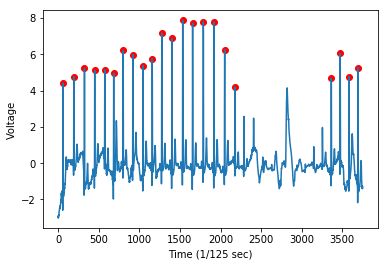

In [113]:
num_to_look = 53
plt.plot(R_peak_train[num_to_look],R_peak_amplitude[num_to_look],"ro")
Plot_ECG(preprocess_train[num_to_look].cpu(),start=0,end=30)
plt.xlabel("Time (1/125 sec)")
plt.ylabel("Voltage")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

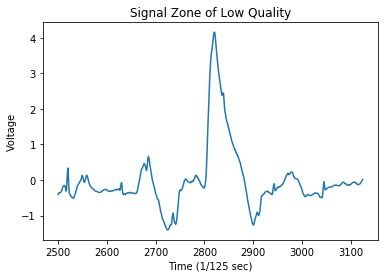

In [116]:
num_to_look = 53
Plot_ECG(preprocess_train[num_to_look].cpu(),start=20,end=25)
plt.title("Signal Zone of Low Quality")
plt.xlabel("Time (1/125 sec)")
plt.ylabel("Voltage")
plt.show

RR std pred vs real

In [76]:
def Find_Peak_Offset_Onset(hearth_beat, Side, half_size_int, c1, c2):
    """
    Take an hearth_beat an find the points of interest at Left or Right of the R peak
    
    The algorithm is based on the paper:
    Online and Offline Determination of QT and PR Interval and QRS Duration in Electrocardiography
    (Bachler et al., 2012)
    The variable name and default value follow the paper. 
    
    Parameters
    ----------
    hearth_beat : list
        Contains the information of one hearth beat
    Side: Left or Right
        Left to detect T Peak T offset QRS offset, Right to detect P onset, P Peak, QRS onset
    half_size_int: int
        half of the RR Mean interval
    c1 : Float
        Used to determined the threshold for QRS offset, onset detection (change in the signal)
    c2 : Float
        Used to determined the threshold for QRS offset, onset detection (change in the derivative of the signal)
        
    Output
    ----------
    If Side = Left Position of the QRS offset, T Peak, T offset 
    If Side = Right Position of the  QRS onset, P Peak, P onset  
    """
    
    hb_length = len(hearth_beat)
    
    if Side == "Right":
        #reverse the template to detect points related to the P wave
        hearth_beat = np.flip(hearth_beat)
    
    
    #find QRS offset/QRS Onset
    derivative = hearth_beat[1:] - hearth_beat[:-1] 
    TA = np.array([])
    TDA = np.array([])

    for i in range(int(half_size_int * 0.8) + 1, int(half_size_int * 0.8) + 25):
        TA  = np.append(TA,np.max(hearth_beat[i : i+4]) - np.min(hearth_beat[i : i+4])) 
        TDA = np.append(TDA,np.max(derivative[i : i+4]) - np.min(derivative[i : i+4]))

    TT = c1 * (np.max(TA) - np.min(TA)) + np.min(TA)
    TD = c2 * (np.max(TDA) - np.min(TDA)) + np.min(TDA)

    for i in range(0, len(TA)):
        if TA[i] < TT or TDA[i] < TD:
            
            if Side == "Right":
                QRS_offset = i + int(half_size_int*1.2) + 4
                break
                
            else:
                QRS_offset = i + int(half_size_int*0.8) + 4
                break        

    #find T peak/ P Peak
    Peak = QRS_offset + np.argmax(hearth_beat[QRS_offset:])

    #find T wave offset/P wave onset see paper for details on how it works

    k = (hearth_beat[Peak] - hearth_beat[-1]) / (Peak-hb_length)
    d = hearth_beat[-1] - k*hb_length
    g = k*np.arange(0,hb_length) + d
    decision = hearth_beat - g
    Peak_offset = np.argmin(decision[Peak:hb_length]) + Peak
    
    if Side == "Right":
        #reverse the points to get the points in the original hearth beat
        QRS_offset = hb_length - QRS_offset - 1
        Peak = hb_length - Peak - 1
        Peak_offset = hb_length - Peak_offset - 1
        
    
    return QRS_offset, Peak, Peak_offset

In [77]:
def Find_ECG_points(data, R_peak, RR_Mean_Interval):
    """
    Take a Batch of ECG data and find the location of all points
    
    The algorithm is based on the paper:
    Online and Offline Determination of QT and PR Interval and QRS Duration in Electrocardiography
    (Bachler et al., 2012)
    The variable name and default value follow the paper
    
    Parameters
    ----------
    data : numpy array
        The ECG Data (batch size x lenght of the ECG recording)
    R_peak: list of list
        List of batch size lenght that contain the contain list of the location of the R peak
    RR_Mean_Interval: list
        List of batch size lenght that contains the Mean RR interval of each ECG
        
    Output
    ----------
    Dictionnary with the location of all points
    """
    
    ECG_points = {}
    ECG_points["Hearth_Beat"] = []
    ECG_points["R_Peak"] = []
    ECG_points["P_Peak"] = []
    ECG_points["T_Peak"] = []
    ECG_points["QRS_offset"] = []
    ECG_points["QRS_onset"] = []
    ECG_points["P_onset"] = []
    ECG_points["T_offset"] = []
    
    
    for recording in range(len(data)):
        #generate the averaged hearth beat
        #Each hearth beat is of variable size
        half_size_int = int(RR_Mean_Interval[recording]//2)
        segments  = []

        for i in R_peak[recording][1:-1]:
            new_heart_beat = data[recording][int(i)-int(half_size_int*0.8): int(i)+int(half_size_int*1.2)]
            segments.append(new_heart_beat)
        
        
        avg_segments = np.mean(segments, axis = 0)
        
        QRS_offset, T_peak, T_offset = Find_Peak_Offset_Onset(avg_segments, "Left", half_size_int, 0.1, 0.1)
        
        QRS_onset, P_peak, P_onset = Find_Peak_Offset_Onset(avg_segments, "Right", half_size_int, 0.5, 0.5)

        ECG_points["Hearth_Beat"].append(avg_segments)
        ECG_points["R_Peak"].append(int(half_size_int*0.8))
        ECG_points["P_Peak"].append(P_peak)
        ECG_points["T_Peak"].append(T_peak)
        ECG_points["QRS_offset"].append(QRS_offset)
        ECG_points["QRS_onset"].append(QRS_onset)
        ECG_points["P_onset"].append(P_onset)
        ECG_points["T_offset"].append(T_offset)
    
    
    return ECG_points

In [85]:
def plot_hearth_beat(ECG_points, index_nb):
    """
    Plot an Hearth Beat with all points of interest
    
    Parameters
    ----------
    ECG_points : Dictionnary
        Contains the location of all point and the hearth beat data
    index_nb: int
        Index of the hearth beat you want to plot
    """
    
    for ECGpoint in ["R_Peak", "QRS_offset", "T_Peak", "T_offset", "QRS_onset", "P_Peak", "P_onset"]:
        plt.plot(ECG_points[ECGpoint][index_nb], ECG_points["Hearth_Beat"][index_nb][ECG_points[ECGpoint][index_nb]], "o")
    Plot_ECG(ECG_points["Hearth_Beat"][index_nb], 0, len(ECG_points["Hearth_Beat"][index_nb]), seconde=False)
    plt.legend(["R", "QRS offset", "T", "T offset", "QRS onset", "P", "P onset" ])
    plt.xlabel("Time (1/125 sec)")
    plt.ylabel("Voltage")
    plt.show()

In [88]:
def Get_RT_Mean_PR_Mean(ECG_points):
    """
    Calculate the mean RT Mean interval and PR_Mean
    
    Parameters
    ----------
    ECG_points : Dictionnary
        Contains the location of all point and the hearth beat data
    """
    RT_Mean = [T_peak-R_peak for T_peak, R_peak in zip(ECG_points["T_Peak"], ECG_points["R_Peak"])]
    PR_Mean = [R_peak-P_peak for R_peak, P_peak in zip(ECG_points["R_Peak"], ECG_points["P_Peak"])]
    
    return RT_Mean, PR_Mean

In [90]:
ECG_points_valid = Find_ECG_points(preprocess_valid.cpu().numpy(), R_peak_valid, Valid_RR_mean)
ECG_points_train = Find_ECG_points(preprocess_train.cpu().numpy(), R_peak_train, Train_RR_mean)

In [92]:
Valid_RT_Mean, Valid_PR_Mean = Get_RT_Mean_PR_Mean(ECG_points_valid)
Train_RT_Mean, Train_PR_Mean = Get_RT_Mean_PR_Mean(ECG_points_train)

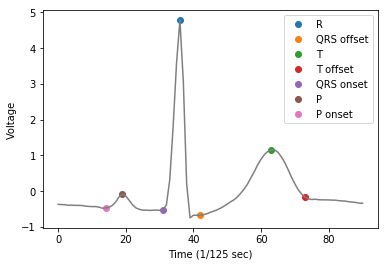

In [93]:
plot_hearth_beat(ECG_points_train, 35)

Check our Regression Score

Valid

In [95]:
print("PR Mean")
a = kendalltau(Valid_PR_Mean, valid_labels[:,0])[0]
print(a)
print("RT Mean")
b = kendalltau(Valid_RT_Mean, valid_labels[:,1])[0]
print(b)
print("RR Std")
c = kendalltau(Valid_RR_std, valid_labels[:,2])[0]
print(b)
print("Kendall Avg")
print(np.mean([a,b,c]))

PR Mean
0.8697791379031147
RT Mean
0.9112549924246455
RR Std
0.9112549924246455
Kendall Avg
0.8777825026948123


Train

In [97]:
print("PR Mean")
a = kendalltau(Train_PR_Mean, train_labels[:,0])[0]
print(a)
print("RT Mean")
b = kendalltau(Train_RT_Mean, train_labels[:,1])[0]
print(b)
print("RR Std")
c = kendalltau(Train_RR_std, train_labels[:,2])[0]
print(b)
print("Kendall Avg")
print(np.mean([a,b,c]))

PR Mean
0.88191830385067
RT Mean
0.9289062593216623
RR Std
0.9289062593216623
Kendall Avg
0.9117318774515741


Main code below note that its the same thing for the T and P peak (we only pass the reverse list for the P peak) so the code could be improve and cut in function...

Calculate RT Mean and PR Mean from the points we have found

<function matplotlib.pyplot.show(*args, **kw)>

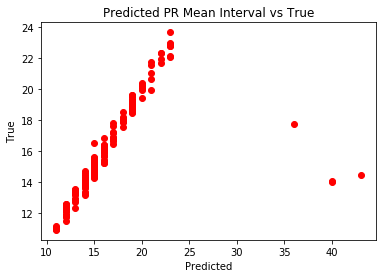

In [98]:
plt.plot(Valid_PR_Mean, valid_labels[:,0], "ro")
plt.title("Predicted PR Mean Interval vs True")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

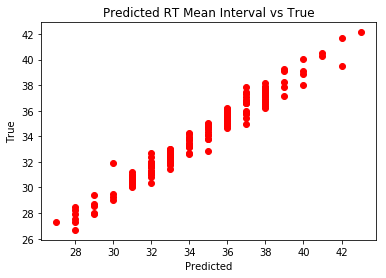

In [99]:
plt.plot(Valid_RT_Mean, valid_labels[:, 1], "ro")
plt.title("Predicted RT Mean Interval vs True")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

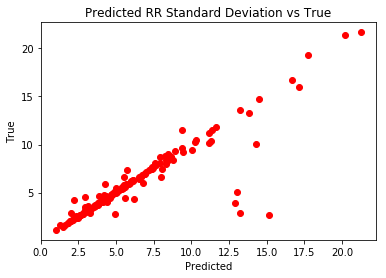

In [100]:
plt.plot(Valid_RR_std, valid_labels[:,-2], "ro")
plt.title("Predicted RR Standard Deviation vs True")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show